# Building a classifier with a qutrit using Qiskit Pulse

## Import dependencies

In [1]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.compiler import transpile
from qiskit.providers.ibmq import least_busy
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks, argrelmin

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import Waveform

from qiskit.tools.monitor import job_monitor

## From the ibmq systems that support qiskit pulse we select the least busy one.

In [2]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline

backend_to_use = "qpu" # {simulator | qpu}
qpus_to_use = ["ibmq_bogota", "ibmq_armonk"] 

if backend_to_use == "qpu":
    # Load IBMQ Account
    #token = "insert your IBMQ account token here"
    #IBMQ.save_account(token)
    if(not IBMQ.active_account()):
        IBMQ.load_account()
    provider = IBMQ.get_provider(hub="ibm-q")
    backends = provider.backends(filters=lambda x: x.name() in qpus_to_use)
    backend = least_busy(backends)
elif backend_to_use == "simulator":
    backend = Aer.get_backend('aer_simulator')
print("Using", backend.name())

backend_config = backend.configuration()

dt = backend_config.dt

backend_defaults = backend.defaults()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 1024

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

Using ibmq_armonk
Qubit 0 has an estimated frequency of 4.97165779296814 GHz.


In [3]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

In [4]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

In [5]:
# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [6]:
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

## Discriminating 0 and 1 states

In [7]:
def create_ground_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the ground state. 
    Depending on drive power this can reveal the 0->1 frequency or the 0->2 frequency. 
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Raised if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try to do this.
    Returns:
        Qobj: Program for ground freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
    
    # print information on the sweep
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")
    
    # Define the drive pulse
    ground_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                                  sigma=drive_sigma,
                                                  amp=drive_power,
                                                  name='ground_sweep_drive_pulse')
    # Create the base schedule
    schedule = pulse.Schedule(name='Frequency sweep starting from ground state.')
    
    schedule |= pulse.Play(ground_sweep_drive_pulse, drive_chan)
    schedule |= measure << schedule.duration
    
    # define frequencies for the sweep
    schedule_freqs = [{drive_chan: freq} for freq in freqs]

    # assemble the program
    # Note: we only require a single schedule since each does the same thing;
    # for each schedule, the LO frequency that mixes down the drive changes
    # this enables our frequency sweep
    ground_freq_sweep_program = assemble(schedule,
                                         backend=backend, 
                                         meas_level=1,
                                         meas_return='avg',
                                         shots=NUM_SHOTS,
                                         schedule_los=schedule_freqs)
    
    return ground_freq_sweep_program

In [8]:
# We will sweep 40 MHz around the estimated frequency, with 75 frequencies
num_freqs = 75
ground_sweep_freqs = default_qubit_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
ground_freq_sweep_program = create_ground_freq_sweep_program(ground_sweep_freqs, drive_power=0.1)

The frequency sweep will go from 4.95165779296814 GHz to 4.99165779296814 GHz using 75 frequencies. The drive power is 0.1.


In [9]:
ground_freq_sweep_job = backend.run(ground_freq_sweep_program)
# ground_freq_sweep_job=backend.retrieve_job('610133435814b9fc61535543')

In [12]:
print(ground_freq_sweep_job.job_id())
job_monitor(ground_freq_sweep_job)

610133435814b9fc61535543
Job Status: job has successfully run


In [13]:
# Get the job data (average)
ground_freq_sweep_data = get_job_data(ground_freq_sweep_job, average=True)

In [14]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [15]:
# do fit in Hz
(ground_sweep_fit_params, 
 ground_sweep_y_fit) = fit_function(ground_sweep_freqs,
                                   ground_freq_sweep_data, 
                                   lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                   [8, 4.975*GHz, 0.1*GHz, 3*GHz] # initial parameters for curve_fit
                                   )

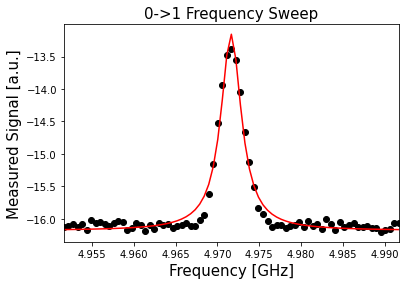

In [16]:
# Note: we are only plotting the real part of the signal
plt.scatter(ground_sweep_freqs/GHz, ground_freq_sweep_data, color='black')
plt.plot(ground_sweep_freqs/GHz, ground_sweep_y_fit, color='red')
plt.xlim([min(ground_sweep_freqs/GHz), max(ground_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("0->1 Frequency Sweep", fontsize=15)
plt.show()

In [17]:
_, cal_qubit_freq, _, _ = ground_sweep_fit_params
print(f"We've updated our qubit frequency estimate from "
      f"{round(default_qubit_freq/GHz, 7)} GHz to {round(cal_qubit_freq/GHz, 7)} GHz.")

We've updated our qubit frequency estimate from 4.9716578 GHz to 4.971628 GHz.


## Perform Rabi experiment to compute the 0 -> 1 pulse amplitude

In [18]:
# experimental configuration
num_rabi_points = 50 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [19]:
# Create schedule
rabi_01_schedules = []
# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_01_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                       amp=drive_amp, 
                                       sigma=drive_sigma, 
                                       name='rabi_01_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(rabi_01_pulse, drive_chan)
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    rabi_01_schedules.append(schedule)

In [20]:
# Assemble the schedules into a program
# Note: We drive at the calibrated frequency.
rabi_01_expt_program = assemble(rabi_01_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [21]:
rabi_01_job = backend.run(rabi_01_expt_program)
# rabi_01_job = backend.retrieve_job('610133efa03abb81d6feb156')

In [22]:
print(rabi_01_job.job_id())
job_monitor(rabi_01_job)

610133efa03abb81d6feb156
Job Status: job has successfully run


In [23]:
# Get the job data (average)
rabi_01_data = get_job_data(rabi_01_job, average=True)


In [24]:
def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

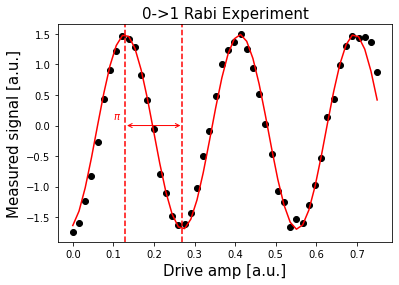

In [25]:
# Note: Only real part of data is plotted
rabi_01_data = np.real(baseline_remove(rabi_01_data))
(rabi_01_fit_params, 
 rabi_01_y_fit) = fit_function(drive_amps,
                               rabi_01_data, 
                               lambda x, A, B, drive_01_period, phi: (A*np.cos(2*np.pi*x/drive_01_period - phi) + B),
                               [4, -4, 0.5, 1.5])

plt.scatter(drive_amps, rabi_01_data, color='black')
plt.plot(drive_amps, rabi_01_y_fit, color='red')

drive_01_period = rabi_01_fit_params[2] 
# account for phi in computing pi amp
pi_amp_01 = (drive_01_period/2/np.pi) *(np.pi+rabi_01_fit_params[3])

plt.axvline(pi_amp_01, color='red', linestyle='--')
plt.axvline(pi_amp_01+drive_01_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_01+drive_01_period/2, 0), xytext=(pi_amp_01,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_01-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('0->1 Rabi Experiment', fontsize=15)
plt.show()

In [26]:
print(f"Pi Amplitude (0->1) = {pi_amp_01}")

Pi Amplitude (0->1) = 0.12879375417400452


## Using these results, we define our 0 -> 1 pi pulse

In [28]:
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_01, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_01')

# Find the 1 -> 2 frequency

In [29]:
def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (SamplePulse): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        SamplePulse: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-cal_qubit_freq)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    
    return sideband_pulse  

In [30]:
def create_excited_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the |1> state. 
    This allows us to obtain the 1->2 frequency. We get from the |0> to |1>
    state via a pi pulse using the calibrated qubit frequency. To do the 
    frequency sweep from |1> to |2>, we use a sideband method by tacking
    a sine factor onto the sweep drive pulse.
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Thrown if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try more than 75 frequencies.
    Returns:
        Qobj: Program for freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
        
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")

    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        sigma=drive_sigma,
                                        amp=drive_power,
                                        name='base_12_pulse')
    schedules = []
    for jj, freq in enumerate(freqs):
        
        # add sideband to gaussian pulse
        freq_sweep_12_pulse = apply_sideband(base_12_pulse, freq)
        
        # add commands to schedule
        schedule = pulse.Schedule(name="Frequency = {}".format(freq))

        # Add 0->1 pulse, freq sweep pulse and measure
        schedule |= pulse.Play(pi_pulse_01, drive_chan)
        schedule |= pulse.Play(freq_sweep_12_pulse, drive_chan) << schedule.duration 
        schedule |= measure << schedule.duration # shift measurement to after drive pulses

        schedules.append(schedule)

    num_freqs = len(freqs)
    
    # draw a schedule
    display(schedules[-1].draw(channels=[drive_chan, meas_chan], label=True, scale=1.0))
    
    # assemble freq sweep program 
    # Note: LO is at cal_qubit_freq for each schedule; accounted for by sideband
    excited_freq_sweep_program = assemble(schedules,
                                          backend=backend, 
                                          meas_level=1,
                                          meas_return='avg',
                                          shots=NUM_SHOTS,
                                          schedule_los=[{drive_chan: cal_qubit_freq}]
                                                         * num_freqs)
    
    return excited_freq_sweep_program

The frequency sweep will go from 4.571627974056236 GHz to 5.001627974056237 GHz using 75 frequencies. The drive power is 0.3.


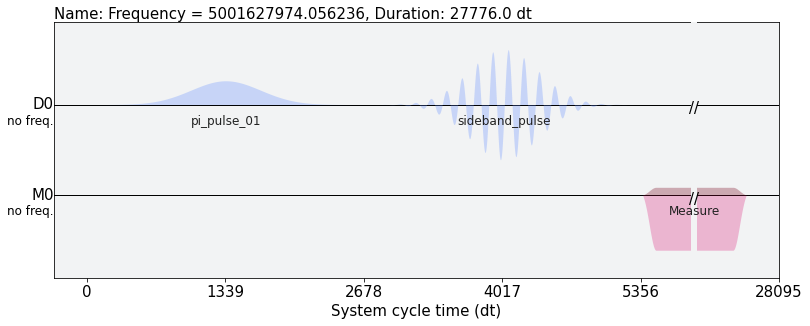

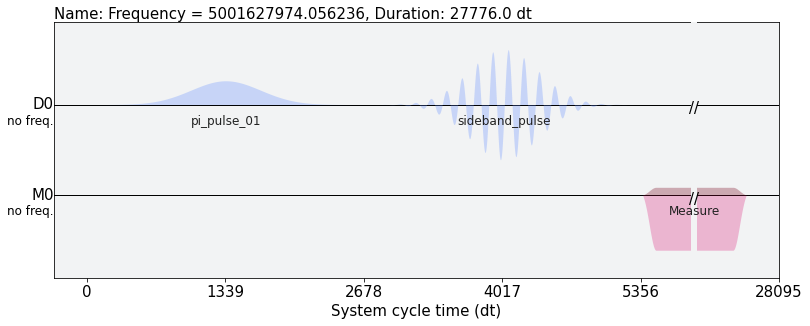

In [31]:
# sweep 400 MHz below 0->1 frequency to catch the 1->2 frequency
num_freqs = 75
excited_sweep_freqs = cal_qubit_freq + np.linspace(-400*MHz, 30*MHz, num_freqs)
excited_freq_sweep_program = create_excited_freq_sweep_program(excited_sweep_freqs, drive_power=0.3)

# Plot an example schedule to make sure it's valid

In [32]:
excited_freq_sweep_job = backend.run(excited_freq_sweep_program)
# excited_freq_sweep_job = backend.retrieve_job('610135000a02a2c2fbcd4007')

In [33]:
print(excited_freq_sweep_job.job_id())
job_monitor(excited_freq_sweep_job)

610135000a02a2c2fbcd4007
Job Status: job has successfully run


In [40]:
# Get job data (avg)
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)

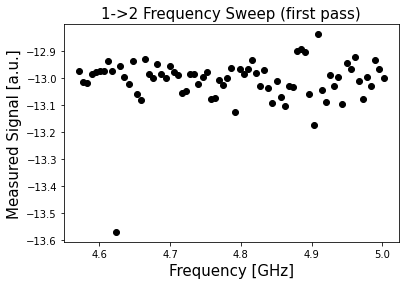

In [41]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
#plt.xlim([min(excited_sweep_freqs/GHz)+0.01, max(excited_sweep_freqs/GHz)]) # ignore min point (is off)
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (first pass)", fontsize=15)
plt.show()

In [44]:
values = excited_freq_sweep_data
ind = np.where(values == np.amin(values))
approx_12_freq = excited_sweep_freqs[ind][0]
print("Freq. dips: ", approx_12_freq)

Freq. dips:  4623925271.353534


The frequency sweep will go from 4.603925271353534 GHz to 4.643925271353534 GHz using 75 frequencies. The drive power is 0.3.


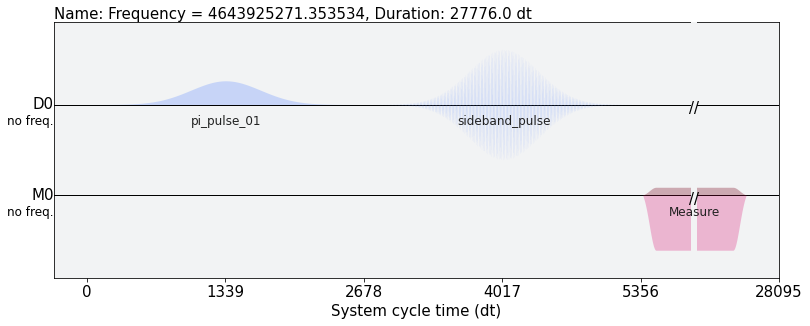

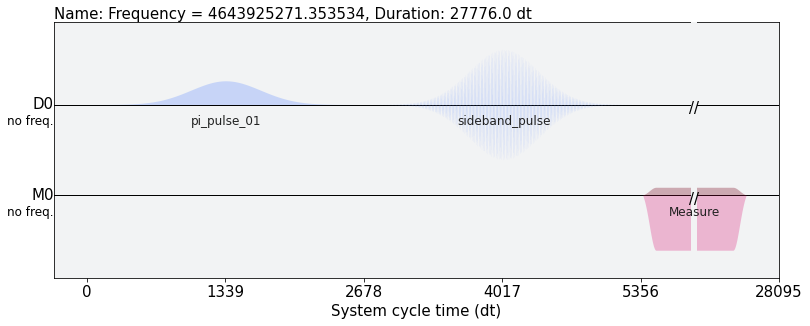

In [45]:
# smaller range refined sweep

num_freqs = 75
refined_excited_sweep_freqs = approx_12_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
refined_excited_freq_sweep_program = create_excited_freq_sweep_program(refined_excited_sweep_freqs, drive_power=0.3)

In [46]:
refined_excited_freq_sweep_job = backend.run(refined_excited_freq_sweep_program)
# refined_excited_freq_sweep_job = backend.retrieve_job('61013608883bbaf8c7fe32b6')

In [47]:
print(refined_excited_freq_sweep_job.job_id())
job_monitor(refined_excited_freq_sweep_job)

61013608883bbaf8c7fe32b6
Job Status: job has successfully run


In [48]:
# Get the refined data (average)
refined_excited_freq_sweep_data = get_job_data(refined_excited_freq_sweep_job, average=True)

In [49]:
# do fit in Hz
(refined_excited_sweep_fit_params, 
 refined_excited_sweep_y_fit) = fit_function(refined_excited_sweep_freqs,
                                     refined_excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-10, 4.56*GHz, 0.05*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

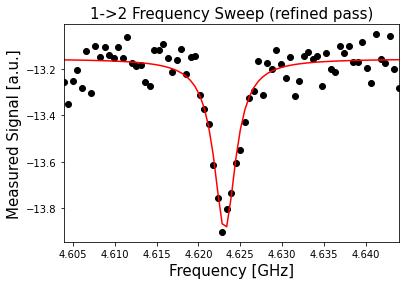

In [50]:
# Note: we are only plotting the real part of the signal
plt.scatter(refined_excited_sweep_freqs/GHz, refined_excited_freq_sweep_data, color='black')
plt.plot(refined_excited_sweep_freqs/GHz, refined_excited_sweep_y_fit, color='red')
plt.xlim([min(refined_excited_sweep_freqs/GHz), max(refined_excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [51]:
_, qubit_12_freq, _, _ = refined_excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 1->2 transition frequency is 4.6231561 GHz.


## 1->2 Rabi Experiment 

In [54]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [55]:
# Create schedule
rabi_12_schedules = []

# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    
    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma,
                                       amp=drive_amp,
                                       name='base_12_pulse')
    # apply sideband at the 1->2 frequency
    rabi_12_pulse = apply_sideband(base_12_pulse, qubit_12_freq)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(pi_pulse_01, drive_chan) # 0->1
    schedule |= pulse.Play(rabi_12_pulse, drive_chan) << schedule.duration # 1->2 Rabi pulse
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    
    rabi_12_schedules.append(schedule)

In [56]:
# Assemble the schedules into a program
# Note: The LO frequency is at cal_qubit_freq to support the 0->1 pi pulse;
# it is modified for the 1->2 pulse using sidebanding
rabi_12_expt_program = assemble(rabi_12_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [57]:
rabi_12_job = backend.run(rabi_12_expt_program)
# rabi_12_job = backend.retrieve_job('61013302a03abbd6cbfeb14a')

In [ ]:
print(rabi_12_job.job_id())
job_monitor(rabi_12_job)

61013302a03abbd6cbfeb14a
Job Status: job is actively running

In [58]:
# Get the job data (average)
rabi_12_data = get_job_data(rabi_12_job, average=True)

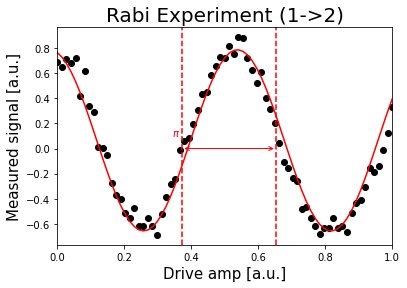

In [99]:
# Note: We only plot the real part of the signal.
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                            rabi_12_data, 
                            lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                            [3, 0.5, 0.9, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2]
# account for phi in computing pi amp
pi_amp_12 = (drive_12_period/2/np.pi) *(np.pi+rabi_12_fit_params[3])
pi_amp_12=0.37256049920143336 #this is the estimated amplitude as we had issues calibrating the real one
plt.xlim(0,1)
plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [100]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.6231561 GHz.
Pi Amplitude (1->2) = 0.37256049920143336


In [101]:
pi_pulse_12 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_12')
# make sure this pulse is sidebanded
pi_pulse_12 = apply_sideband(pi_pulse_12, qubit_12_freq)

## Build the 0, 1, 2 discriminator 

In [102]:
# Create the three schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan)
one_schedule |= measure << one_schedule.duration

# Excited state schedule
two_schedule = pulse.Schedule(name="two schedule")
two_schedule |= pulse.Play(pi_pulse_01, drive_chan)
two_schedule |= pulse.Play(pi_pulse_12, drive_chan) << two_schedule.duration
two_schedule |= measure << two_schedule.duration

In [103]:
# Assemble the schedules into a program
IQ_012_program = assemble([zero_schedule, one_schedule, two_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: cal_qubit_freq}] * 3)

In [120]:
 IQ_012_job = backend.run(IQ_012_program)
# IQ_012_job = backend.retrieve_job('61013d120a02a2031ecd4054')

In [105]:
print(IQ_012_job.job_id())
job_monitor(IQ_012_job)

61013d120a02a2031ecd4054
Job Status: job has successfully run


In [106]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

In [107]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    #plt.xlim(x_min, x_max)
    #plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

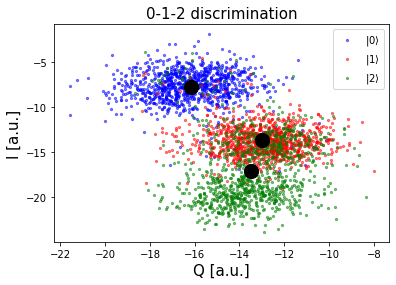

In [108]:
x_min = -10
x_max = 20
y_min = -25
y_max = 10
IQ_012_plot(x_min, x_max, y_min, y_max)

In [110]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [111]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  
two_data_reshaped = reshape_complex_vec(two_data)  

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape) # verify IQ data shape

(3072, 2)


In [112]:
# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

3072


In [113]:
# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

LinearDiscriminantAnalysis()

In [114]:
# test on some simple data 
print(LDA_012.predict([[0, 0], [-10, 0], [-15, -5]]))

[1. 0. 0.]


In [115]:
# Compute accuracy
score_012 = LDA_012.score(IQ_012_test, state_012_test)
print(score_012)

0.8040364583333334


In [118]:
# Plot separatrix on top of scatter
def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

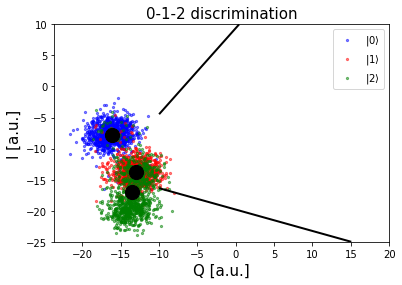

In [119]:
IQ_012_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

## We generate our sample data

In [123]:
def generate_annulus_data(samples):
    """Generate the annulus pattern (tricrown) data
    Args:
        n_samples (int): Number of samples to generate
    Returns:
        data (tuple):
            X (np-array): x, y positions
            y (np-array): classes
    """
    centers = [[0,0],[0,0]]
    radii = [np.sqrt(.8 - 2/np.pi), np.sqrt(.8)]
    points=[]
    classes=[]
    dim = 2
    for i in range(samples):
        X = 2 * (np.random.rand(dim)) - 1
        y=0
        for j,(r,c) in enumerate(zip(radii, centers)):
            if np.linalg.norm(X - c) > r:
                y = j + 1
        points.append(X)
        classes.append(y)

    data = np.array(points), np.array(classes)
    settings = centers, radii  

    return data, settings

In [190]:
(data,settings) = generate_annulus_data(200)

## We train our model

In [158]:
def apply_sideband(pulse, freq, phi, cal_qubit_freq, drive_samples):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (SamplePulse): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        SamplePulse: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-cal_qubit_freq)*t_samples+phi) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_p')
    
    return sideband_pulse 

## We here define the pulse implementing an X or Y rotation in the desired qutrit subspace

In [159]:
def get_gate_funct(cal_qubit_freq, qubit_12_freq, pi_amp_01, pi_amp_12, drive_samples, drive_sigma):

    def xy_gate(sub, xy, th): ## xy w is the weight, b the free parameter and x our data point
        """ Returns the pulse that implements the desired gate. sub refers to the subspace, and can be '01' or '12' and 
              xy can be 0 or 1 , X --> 0 and Y --> 1 (i.e., selects the axis) and th is the angle of rotation """

        """ sub can be '01' or '12' and indicates the subspace we want to adress"""
        if sub == '01':
           freq = cal_qubit_freq
           A = pi_amp_01
        elif sub == '12':
           freq = qubit_12_freq
           A = pi_amp_12

        """ xy can be 0 or 1 , X --> 0 and Y --> 1 """
        if xy == 0:
            phi = 0
        elif xy == 1:
            phi = 0.5 * np.pi


        """Generate gaussian pulse first"""
        drive_amp = (th) * A / np.pi
        base_pulse = pulse_lib.gaussian(duration=drive_samples,
                                          sigma=drive_sigma,
                                          amp=drive_amp,
                                          name='base_pulse')
        
        sideband_pulse = apply_sideband(base_pulse, freq, phi, cal_qubit_freq, drive_samples)

        return sideband_pulse
    return xy_gate

# Learning scheme: define layers, concatenate pulses (i.e., operations), measure at the end

## STARTING AFTER FINISHING CALIBRATION

In [160]:
xy_gate = get_gate_funct(cal_qubit_freq, qubit_12_freq, pi_amp_01, pi_amp_12, drive_samples, drive_sigma)

#X_gate = xy_gate(sub, 0, w, th, x)
#Y_gate = xy_gate(sub, 1, w, th, x)

# layer_angles = [...] 4-dimensional array containing the ordered sequence of angles to apply to the different gates.
layer_angles = [12, 235, 245, 234] #### DUMMY ANGLES

sub_sequence = ['01', '01', '12', '12']
gate_sequence = [0, 1, 0, 1]

num_gates_per_layer = 4

In [204]:
def algorithm_structure(num_layers, sub_sequence, gate_sequence):
    
    sub_sequence = np.tile(sub_sequence, num_layers)
    gate_sequence = np.tile(gate_sequence, num_layers)

    def opt_iteration(layer_angles):
        
        total_num_gates = len(layer_angles)
        schedule = pulse.Schedule(name='Layer construction')

        for g in range(total_num_gates):
            gate = xy_gate(sub_sequence[g], gate_sequence[g], layer_angles[g])
            schedule += pulse.Play(gate, drive_chan)
            
        schedule |= measure << schedule.duration
          

        # assemble the program
        opt_iteration_program = assemble(schedule,
                                backend=backend, 
                                meas_level=1, ### extract (I, Q) coordinates in order to classify is with our LDA
                                meas_return='single',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}] * num_layers) ########## WE STILL NEED TO FIGURE THIS OUT
        
        # run the job
        opt_iteration_program_job = backend.run(opt_iteration_program)
        print(opt_iteration_program_job.job_id())
        job_monitor(opt_iteration_program_job)

        opt_iteration_program_data = get_job_data(opt_iteration_program_job, average=False)
        
        data2predict = []
        for i, d in enumerate(opt_iteration_program_data[0]):
            data2predict.append([np.real(d), np.imag(d)])
                
        predicted_labels = LDA_012.predict(data2predict)

        probabilities,_ = np.histogram(predicted_labels, bins = 3, density = False)

        return probabilities/NUM_SHOTS

    return opt_iteration

In [205]:
num_layers = 3

opt_iteration = algorithm_structure(num_layers, sub_sequence, gate_sequence)
#angles = np.random.rand(4) * np.pi/2
#probs = opt_iteration(angles)

In [183]:
def parse_params(params, num_layers, data_dim):
  """
  Helper function: parse parameter vector params to model parameters W and b.
  """
  W = params[:num_layers*4*data_dim].reshape((num_layers*4, data_dim))
  b = params[num_layers*4*data_dim:]
  return W, b

def eval(params, xs, ys, num_layers):
  """
  Evaluate the model on a given dataset with datapoints xs and true labels ys.
  """
  W, b = parse_params(params, num_layers, DATA_DIM)
  loss = 0
  for x,y in zip(xs, ys):
    angles = W@x + b
    probs = opt_iteration(angles) 
    loss += 1 - probs[y]
  return loss

def train(xs, ys, num_layers):
  """
  Train the model with num_layers on dataset xs and ys, return results from scipy.optimize.minimize.
  """
  init_params = 2 * np.random.rand(num_layers*4*(DATA_DIM+1)) - 1
  result = minimize(eval, init_params, args=(xs, ys, num_layers), method="L-BFGS-B")
  return result

In accordance with the paper we choose the three-class annulus problem to test the classifier. The data points are uniformly distributed between  𝑥∈[−1,1]2  and the label is choosen according to the distance from the origin.

In [ ]:
data_dim = 2
num_layers = 3
params = np.load("qutrit_classifier_3layers_optimal_params.npy")
W,b = parse_params(params, num_layers, data_dim)

preds = []
for i in data[0]:
    angles = W@i + b
    probs = opt_iteration(angles)
    ind = np.where(probs == np.amax(probs))
    preds.append(ind)
print(preds)

6101542d79d0d0dcd8776625
Job Status: job has successfully run
6101543be2fdbc0dd70cc99e
Job Status: job has successfully run
61015449883bba2e70fe343e
Job Status: job has successfully run
61015457aeb9d8ad5bc5da6b
Job Status: job has successfully run
6101547056e1ea01b20ca1ea
Job Status: job has successfully run
6101549d883bbabcaafe3443
Job Status: job has successfully run
610154caa03abb96a3feb2a8
Job Status: job has successfully run
610154e5aeb9d836e2c5da73
Job Status: job has successfully run
6101555d68ba6122c8b07e23
Job Status: job has successfully run
6101556b57de93abf18571c9
Job Status: job has successfully run
61015584e2fdbc08290cc9b1
Job Status: job has successfully run
61015592e2fdbc82a20cc9b2
Job Status: job has successfully run
610155e05814b9c2c85356c0
Job Status: job has successfully run
610155ee68ba614595b07e26
Job Status: job has successfully run
6101569268ba6120acb07e32
Job Status: job is queued (1)     

# References

The calibration part of this work has been done using the guidelines from https://qiskit.org/textbook/ch-quantum-hardware/accessing_higher_energy_states.html